In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip uninstall -y torch torchvision

In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install ogb
!pip install rdkit-pypi

     |████████████████████████████████| 7.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 407 kB 5.4 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
     |████████████████████████████████| 78 kB 3.5 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=aaf7100f9b0a0fbb9b36486598578c435a754b434327fcb162d80321c8ac43e9
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
     |████████████████████████████████| 20.6 MB 18.2 MB/s 


## Importamos las librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# For Dataset generation and visualization
from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
from ogb.graphproppred.mol_encoder import AtomEncoder
from ogb.utils.features import atom_to_feature_vector, bond_to_feature_vector

# Extras
import os.path as osp
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from math import sqrt


## Dataset visualization

In [ ]:
csv_path = '/content/drive/MyDrive/GNN/ampc/training_ds.csv'
molecules = pd.read_csv(csv_path).sample(10).values

## Data Handling of Graphs

In [3]:
# Pytorch geometric modules
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader

# Torch
import torch

class moleculesDS(InMemoryDataset):
  def __init__(self, root, csv_path, transform=None, pre_transform=None):
    self.csv_path = csv_path
    super().__init__(root, transform, pre_transform)
    self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_file_names(self):
    return []

  @property
  def processed_file_names(self):
    # After preprocesing usinf comment columns and NOT Decoys
    files = 'final_v2.pt'
    return files


  def download(self):
    pass

  def process(self):
    data_list = []
    molecules = pd.read_csv(self.csv_path).values

    for smiles, act in molecules:
        y = torch.tensor(act, dtype=torch.float32).reshape(-1, 1)
        
        # Throw molecules in wich molecules can not be obtanined
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            mol = None
        if mol is None:
            print('mol is none')
            continue

        all_node_feats = []
        for atom in mol.GetAtoms():
            node_feats = atom_to_feature_vector(atom)
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        x = torch.tensor(all_node_feats, dtype=torch.long).view(-1, 9)

        edge_attr = []
        edge_index = []
        for bond in mol.GetBonds():

            bond_feats = bond_to_feature_vector(bond)
            edge_attr.append([bond_feats, bond_feats])

            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_index += [[i, j], [j, i]]


        edge_attr = torch.tensor(edge_attr)
        edge_attr = edge_attr.to(torch.long).view(-1, 3)

        edge_index = torch.tensor(edge_index)
        edge_index = edge_index.t().to(torch.long).view(2, -1)


        data = Data(x=x, edge_index=edge_index, edge_attr = edge_attr, y=y.reshape(1, 1), smiles=smiles)

        data_list.append(data)

    data, slices = self.collate(data_list)
    torch.save((data, slices), self.processed_paths[0])


---

# Model

In [4]:
from torch_geometric.nn import GATv2Conv, GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm

from torch.nn import Sequential, ModuleList, ReLU, Linear, Dropout
import torch.nn.functional as F

from torch_geometric.nn.models import AttentiveFP

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        self.emb = AtomEncoder(in_channels)
        self.bondemb = BondEncoder(3)

        self.AttentiveFP = AttentiveFP(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=1,
                     edge_dim=3, num_layers=num_layers, num_timesteps=1, dropout=dropout)
        
        
    def forward(self, x, edge_index, edge_attr, batch_index):
        x = self.emb(x)
        edge_attr = self.bondemb(edge_attr)
        x = self.AttentiveFP(x, edge_index, edge_attr, batch_index)
        return x

# Training

In [5]:
from sklearn.metrics import precision_score, matthews_corrcoef, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rdkit.Chem as Chem
from rdkit.Chem import AllChem

from statistics import mean

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')


def get_metrics(y_true, y_pred):
    y_pred = np.rint(y_pred)

    precision = precision_score(y_true, y_pred)
    matthews = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, matthews, accuracy


def training_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    h = model(x, edge_index, edge_attr, batch_index)

    loss = criterion(h.reshape(-1), y_target.reshape(-1))
    loss.backward()

    optimizer.step()

    return float(loss), h


@torch.no_grad()
def test_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion):
    model.eval()

    h = model(x, edge_index, edge_attr, batch_index)

    loss = criterion(h, y_target)

    return float(loss), h


def epoch(model, dataloader, criterion, optimizer, training=True):

    total_loss = 0
    total_examples = 0

    y_target_list = []
    h_list = []

    for data in dataloader:
        data = data.to(DEVICE)
        y_target = data.y
        x, edge_index, edge_attr, batch_index = data.x, data.edge_index, data.edge_attr, data.batch

        y_target = y_target.reshape(-1, 1)

        if training:
            loss, h = training_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion, optimizer)
        else:
            loss, h = test_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion)

        total_loss += loss * len(y_target)
        total_examples += len(y_target)

        y_target_list.append(y_target)
        h_list.append(h)

    y_true = torch.cat(y_target_list, dim=0).detach().cpu().numpy()
    y_pred = torch.sigmoid(torch.cat(h_list, dim=0)).detach().cpu().numpy()

    precision_score, matthews_corrcoef, accuracy = get_metrics(y_true, y_pred)

    return total_loss/total_examples, precision_score, matthews_corrcoef, accuracy


def training_init(EPOCHS, model, dataloaders, criterion, optimizer):
    train_metrics = []
    test_metrics = []
    test_precision_score_list = []

    train_dataloader, test_dataloader = dataloaders

    for e in range(EPOCHS):
        train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = epoch(
            model, train_dataloader, criterion, optimizer)
        train_metrics.append([train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy])

        test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = epoch(
            model, test_dataloader, criterion, optimizer, training=False)
        test_metrics.append([test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy])
        test_precision_score_list.append(test_precision_score)

        if e % 20 == 0:
            print(f'Epoch {e}')
            print(f'loss {train_total_loss:.4f} | precision_score {train_precision_score:.4f} | matthews_corrcoef {train_matthews_corrcoef:.4f} | accuracy {train_accuracy:.4f}')
            print(f'loss {test_total_loss:.4f} | precision_score {test_precision_score:.4f} | matthews_corrcoef {test_matthews_corrcoef:.4f} | accuracy {test_accuracy:.4f}')
            print()

    # For optimization
    test_precision_score = mean(test_precision_score_list)
    return test_precision_score, (train_metrics, test_metrics)

def get_dataset_and_weight(root, file_name, batch_size, shuffle=True):
    dataset = moleculesDS(root = root, csv_path = file_name)
    loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

    pos_weight = len(dataset.data.y.reshape(-1)) / dataset.data.y.reshape(-1).sum()
    pos_weight = torch.Tensor([pos_weight])
    print(f'El número de valores en el dataset es de: {len(dataset.data.y.reshape(-1))} y tiene {dataset.data.y.sum()} positivos')
    return loader, pos_weight

def get_model_criterion_optimizer(pos_weight, lr, hidden_channels, num_layers, dropout, weight_decay = 1**-6):
    model = GCN(9, hidden_channels, num_layers, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
    return model, criterion, optimizer

# For Optuna
# - - - - - - - - - - - - - - - - - - - - - - - - 
'''
Best trial:
Params: 
    batch_size: 411
    lr: 0.00010701665292432792
    num_layers: 2
    hidden_channels: 220
    dropout: 0.4
'''
'''
Best trial:
  Value:  0.23863636363636365
  Params: 
    batch_size: 411
    lr: 0.005306842152115659
    weight_decay: 1.4144750379298322e-05
    num_layers: 2
    hidden_channels: 120
    dropout: 0.5
'''



def get_model_criterion_optimizer_for_optuna(trial, weight):
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True, )
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 2, 5, step=1)
    hidden_channels = trial.suggest_int('hidden_channels', 20, 520, step=100)
    dropout = 0.5 #trial.suggest_float("dropout", 0.4, 0.6, step=0.1)
    return get_model_criterion_optimizer(weight, lr, hidden_channels, num_layers, dropout, weight_decay = weight_decay)

# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_all_optuna(trial, root, file_name, batch_size, shuffle=True):
    dataloader, weight = get_dataset_and_weight(root, file_name, batch_size, shuffle=shuffle)

    model, criterion, optimizer = get_model_criterion_optimizer_for_optuna(
        trial, weight)

    return model, criterion, optimizer, dataloader

Device is: cuda


El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
El número de valores en el dataset es de: 977 y tiene 37.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9348 | precision_score 0.0774 | matthews_corrcoef -0.0105 | accuracy 0.4770
loss 0.9080 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9454 | precision_score 0.2481 | matthews_corrcoef 0.3303 | accuracy 0.8080
loss 0.7087 | precision_score 0.1351 | matthews_corrcoef 0.2463 | accuracy 0.8240

Epoch 40
loss 0.6859 | precision_score 0.3682 | matthews_corrcoef 0.4908 | accuracy 0.8734
loss 0.5279 | precision_score 0.1824 | matthews_corrcoef 0.3474 | accuracy 0.8516

Epoch 60
loss 0.5381 | precision_score 0.4194 | matthews_corrcoef 0.5607 | accuracy 0.8928
loss 0.4300 | precision_score 0.3061 | matthews_corrcoef 0.4692 | accuracy 0.9232

Epoch 80
loss 0.4001 | precision_score 0.4767 | matthews_corrcoef 0.6199 | accuracy 0.9127
loss 0.4179 | precision_score 0.3649 | matthews_corrcoef 0.4904 | accuracy 0.9417

Epoch 100
loss 0.3084 | precision_score 0.5492 | matthews_corrcoef 0.6895 | accuracy 0.9334
loss 0.4068 | precision_score 0.4203 |

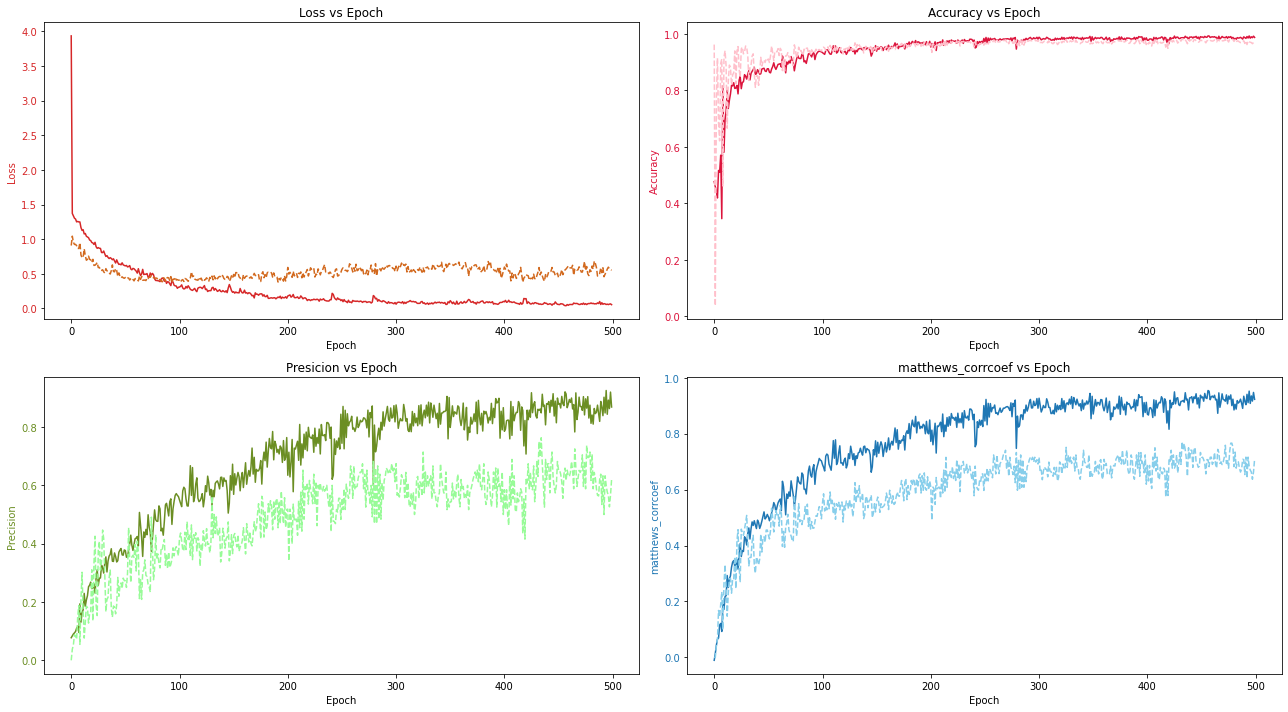

In [14]:
'''
Best trial:
  Value:  0.37037037037037035
  Params: 
    batch_size: 511
    lr: 0.04870277940137615
    weight_decay: 1.0357051478357444e-05
    num_layers: 1
    hidden_channels: 220
    dropout: 0.6
'''
'''
{'batch_size': 511, 
'lr': 0.004932917425534324, 
'weight_decay': 0.001513000379300766, 
'num_layers': 3, 
'hidden_channels': 300, 
'dropout': 0.4}
'''
'''
{
    # ESTABLE
    'batch_size': 411, 
    'lr': 0.0003613844023759524, 
    'weight_decay': 2.2537519543024984e-07, 
    'num_layers': 3, 
    'hidden_channels': 300, 
    'dropout': 0.6000000000000001}. 
'''
'''
Trial 12 finished with value: 
0.2555535528023482 and parameters: 
{'lr': 0.001164884005365969, 
'weight_decay': 3.7540522058417304e-06, 
'num_layers': 2, 
'hidden_channels': 320}. 
'''
'''
Trial 9 finished with value: 
0.21089850679388622 and parameters: 
{'lr': 0.0015294022249668856, 
'weight_decay': 6.502161136338155e-05, 
'num_layers': 2, 
'hidden_channels': 420}. 

'''

if __name__ == '__main__':
    batch_size_train = 500
    batch_size_test = 100

    root = '/content/drive/MyDrive/GNN/training'
    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_wdec_ds.csv' 
    train_dataloader, weight = get_dataset_and_weight(
        root, train_file_name, batch_size_train, shuffle=True)

    root = '/content/drive/MyDrive/GNN/testing'
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_wdec_ds.csv' 
    test_dataloader, _ = get_dataset_and_weight(
        root, test_file_name, batch_size_test, shuffle=False)

    num_layers = 2
    hidden_channels = 320
    dropout = 0.5
    lr = 0.0015294022249668856 # learning was inestable, so small rl will be try
    weight_decay = 3.7540522058417304e-06
    model, criterion, optimizer = get_model_criterion_optimizer(
        weight, lr, hidden_channels, num_layers, dropout, weight_decay=weight_decay)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 500
    _, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)
    
    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    fig, ax1 = plt.subplots(2, 2, figsize=(18,10))
    t = range(EPOCHS)


    # Loss
    ax1[0, 0].set_title('Loss vs Epoch')
    ax1[0, 0].set_xlabel('Epoch')
    ax1[0, 0].set_ylabel('Loss', color='tab:red')
    ax1[0, 0].tick_params(axis='y', labelcolor='tab:red')
    ax1[0, 0].plot(t, train_total_loss, color='tab:red')
    ax1[0, 0].plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # Presicion
    ax1[1, 0].set_title('Presicion vs Epoch')
    ax1[1, 0].set_xlabel('Epoch')
    ax1[1, 0].set_ylabel('Precision', color='olivedrab')  
    ax1[1, 0].tick_params(axis='y', labelcolor='olivedrab')

    ax1[1, 0].plot(t, train_precision_score, color='olivedrab')
    ax1[1, 0].plot(t, test_precision_score, color='palegreen', linestyle='dashed')

    # matthews_corrcoef
    ax1[1, 1].set_title('matthews_corrcoef vs Epoch')
    ax1[1, 1].set_xlabel('Epoch')
    ax1[1, 1].set_ylabel('matthews_corrcoef', color='tab:blue')  
    ax1[1, 1].tick_params(axis='y', labelcolor='tab:blue')

    ax1[1, 1].plot(t, train_matthews_corrcoef, color='tab:blue')
    ax1[1, 1].plot(t, test_matthews_corrcoef, color='skyblue', linestyle='dashed')

    # Accuracy
    ax1[0, 1].set_title('Accuracy vs Epoch')
    ax1[0, 1].set_ylabel('Accuracy', color='crimson')  
    ax1[0, 1].set_xlabel('Epoch')
    ax1[0, 1].tick_params(axis='y', labelcolor='crimson')

    ax1[0, 1].plot(t, train_accuracy, color='crimson')
    ax1[0, 1].plot(t, test_accuracy, color='pink', linestyle='dashed')

    fig.tight_layout() 
    plt.show()


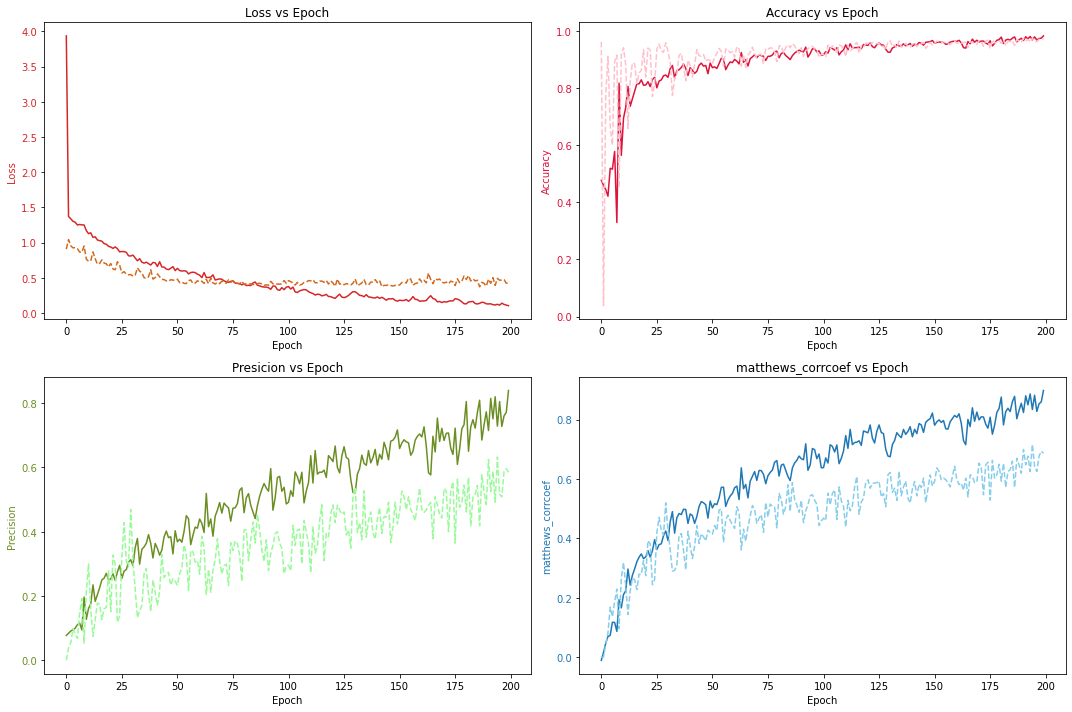

In [13]:
fig, ax1 = plt.subplots(2, 2, figsize=(18,10))
t = range(EPOCHS)


# Loss
ax1[0, 0].set_title('Loss vs Epoch')
ax1[0, 0].set_xlabel('Epoch')
ax1[0, 0].set_ylabel('Loss', color='tab:red')
ax1[0, 0].tick_params(axis='y', labelcolor='tab:red')
ax1[0, 0].plot(t, train_total_loss, color='tab:red')
ax1[0, 0].plot(t, test_total_loss, color='chocolate', linestyle='dashed')

# Presicion
ax1[1, 0].set_title('Presicion vs Epoch')
ax1[1, 0].set_xlabel('Epoch')
ax1[1, 0].set_ylabel('Precision', color='olivedrab')  
ax1[1, 0].tick_params(axis='y', labelcolor='olivedrab')

ax1[1, 0].plot(t, train_precision_score, color='olivedrab')
ax1[1, 0].plot(t, test_precision_score, color='palegreen', linestyle='dashed')

# matthews_corrcoef
ax1[1, 1].set_title('matthews_corrcoef vs Epoch')
ax1[1, 1].set_xlabel('Epoch')
ax1[1, 1].set_ylabel('matthews_corrcoef', color='tab:blue')  
ax1[1, 1].tick_params(axis='y', labelcolor='tab:blue')

ax1[1, 1].plot(t, train_matthews_corrcoef, color='tab:blue')
ax1[1, 1].plot(t, test_matthews_corrcoef, color='skyblue', linestyle='dashed')

# Accuracy
ax1[0, 1].set_title('Accuracy vs Epoch')
ax1[0, 1].set_ylabel('Accuracy', color='crimson')  
ax1[0, 1].set_xlabel('Epoch')
ax1[0, 1].tick_params(axis='y', labelcolor='crimson')

ax1[0, 1].plot(t, train_accuracy, color='crimson')
ax1[0, 1].plot(t, test_accuracy, color='pink', linestyle='dashed')

fig.tight_layout() 
plt.show()

## Optuna hyperparameter search

In [6]:
!pip install optuna
# !pip install rdkit-pypi

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 43.2 MB/s 
     |████████████████████████████████| 80 kB 9.1 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 149 kB 51.3 MB/s 
     |████████████████████████████████| 112 kB 52.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=50b802074d1d0311a66903d01486021522d05964fac2d842ab547d04c0c6a4e0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [7]:
import torch
import optuna
import pandas as pd
from optuna.trial import TrialState

[I 2021-11-24 02:22:21,685] A new study created in memory with name: no-name-bd1ab339-2716-4a40-b351-d5d44a91049e


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.5744 | precision_score 0.0747 | matthews_corrcoef -0.0359 | accuracy 0.2729
loss 1.1500 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.4534 | precision_score 0.0776 | matthews_corrcoef -0.0107 | accuracy 0.4409
loss 1.0148 | precision_score 0.0394 | matthews_corrcoef 0.0399 | accuracy 0.0768

Epoch 40
loss 1.3777 | precision_score 0.0892 | matthews_corrcoef 0.0322 | accuracy 0.5210
loss 0.9562 | precision_score 0.0571 | matthews_corrcoef 0.0472 | accuracy 0.8035

Epoch 60
loss 1.3570 | precision_score 0.0866 | matthews_corrcoef 0.0246 | accuracy 0.4952
loss 0.9593 | precision_score 0.0679 | matthews_corrcoef 0.1108 | accuracy 0.6755

Epoch 80
loss 1.3231 | precision_score 0.0986 | matthews_corrcoef 0.0651 | accuracy 0.5355
loss 0.9449 | precision_score 0.0717 | matthews_corrcoef 0.1198 | accura

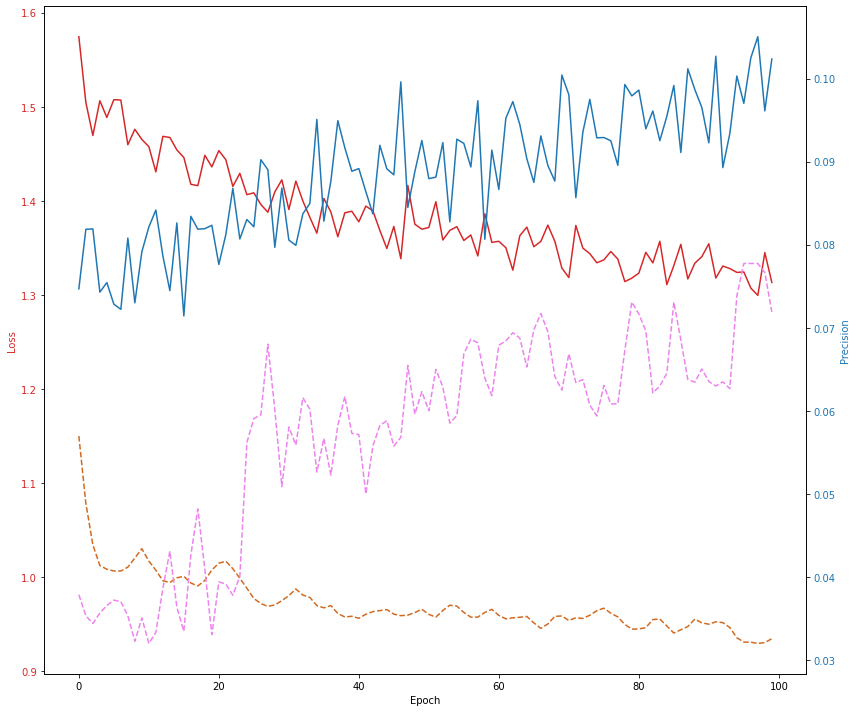

[I 2021-11-24 02:28:28,759] Trial 0 finished with value: 0.057280837564999076 and parameters: {'lr': 1.8459707434461382e-06, 'weight_decay': 0.0027175431598270836, 'num_layers': 3, 'hidden_channels': 420}. Best is trial 0 with value: 0.057280837564999076.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.4458 | precision_score 0.0838 | matthews_corrcoef 0.0121 | accuracy 0.5436
loss 1.0709 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.0085 | precision_score 0.2342 | matthews_corrcoef 0.2989 | accuracy 0.8043
loss 0.8677 | precision_score 0.0872 | matthews_corrcoef 0.1714 | accuracy 0.7103

Epoch 40
loss 0.7909 | precision_score 0.3186 | matthews_corrcoef 0.4240 | accuracy 0.8512
loss 0.8324 | precision_score 0.0988 | matthews_corrcoef 0.2354 | accuracy 0.6796

Epoch 60
loss 0.7011 | precision_score 0.3372 | matthews_corrcoef 0.4579 | accuracy 0.8581
loss 0.4605 | precision_score 0.2913 | matthews_corrcoef 0.4557 | accuracy 0.9181

Epoch 80
loss 0.6280 | precision_score 0.3484 | matthews_corrcoef 0.4870 | accuracy 0.8606
loss 0.4618 | precision_score 0.2478 | matthews_corrcoef 0.3977 | accuracy

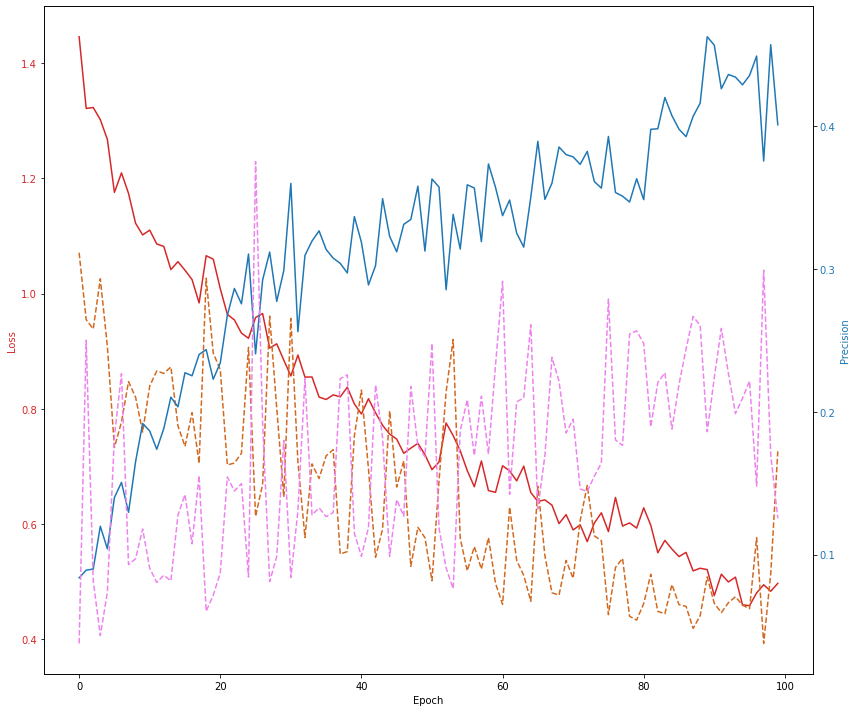

[I 2021-11-24 02:31:54,297] Trial 1 finished with value: 0.16867568939624616 and parameters: {'lr': 0.0007849377982937009, 'weight_decay': 0.0002790872368937068, 'num_layers': 4, 'hidden_channels': 220}. Best is trial 1 with value: 0.16867568939624616.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3802 | precision_score 0.0801 | matthews_corrcoef -0.0004 | accuracy 0.4529
loss 0.9893 | precision_score 0.0476 | matthews_corrcoef 0.0484 | accuracy 0.5343

Epoch 20
loss 1.2868 | precision_score 0.1082 | matthews_corrcoef 0.0912 | accuracy 0.5761
loss 0.9349 | precision_score 0.0710 | matthews_corrcoef 0.1182 | accuracy 0.6899

Epoch 40
loss 1.1998 | precision_score 0.1459 | matthews_corrcoef 0.1845 | accuracy 0.6597
loss 0.8516 | precision_score 0.0893 | matthews_corrcoef 0.1707 | accuracy 0.7267

Epoch 60
loss 1.1351 | precision_score 0.1679 | matthews_corrcoef 0.2168 | accuracy 0.7135
loss 0.8044 | precision_score 0.1053 | matthews_corrcoef 0.1948 | accuracy 0.7779

Epoch 80
loss 1.1169 | precision_score 0.1872 | matthews_corrcoef 0.2465 | accuracy 0.7440
loss 0.8026 | precision_score 0.1043 | matthews_corrcoef 0.1932 | accurac

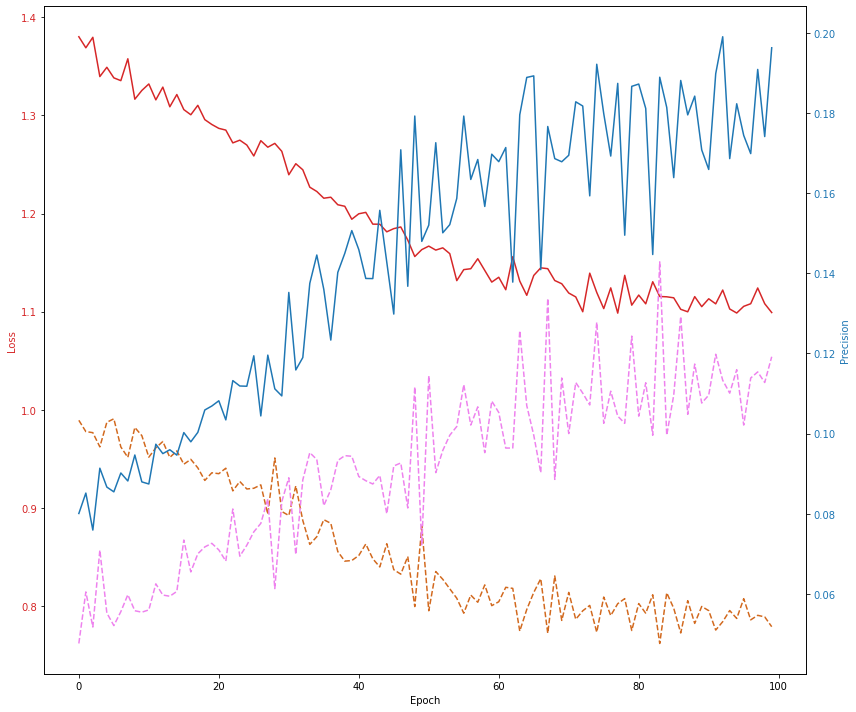

[I 2021-11-24 02:35:21,197] Trial 2 finished with value: 0.09174018176222037 and parameters: {'lr': 2.6973579592920693e-05, 'weight_decay': 0.003647328245361531, 'num_layers': 4, 'hidden_channels': 220}. Best is trial 1 with value: 0.16867568939624616.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3552 | precision_score 0.0803 | matthews_corrcoef 0.0007 | accuracy 0.5114
loss 1.0181 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.3215 | precision_score 0.0944 | matthews_corrcoef 0.0548 | accuracy 0.4974
loss 0.9732 | precision_score 0.0625 | matthews_corrcoef 0.0968 | accuracy 0.6469

Epoch 40
loss 1.2952 | precision_score 0.1055 | matthews_corrcoef 0.0923 | accuracy 0.5301
loss 0.9402 | precision_score 0.0722 | matthews_corrcoef 0.1170 | accuracy 0.7073

Epoch 60
loss 1.2674 | precision_score 0.1120 | matthews_corrcoef 0.1163 | accuracy 0.5348
loss 0.9193 | precision_score 0.0712 | matthews_corrcoef 0.1308 | accuracy 0.6540

Epoch 80
loss 1.2233 | precision_score 0.1463 | matthews_corrcoef 0.1721 | accuracy 0.6845
loss 0.8305 | precision_score 0.1198 | matthews_corrcoef 0.2122 | accuracy

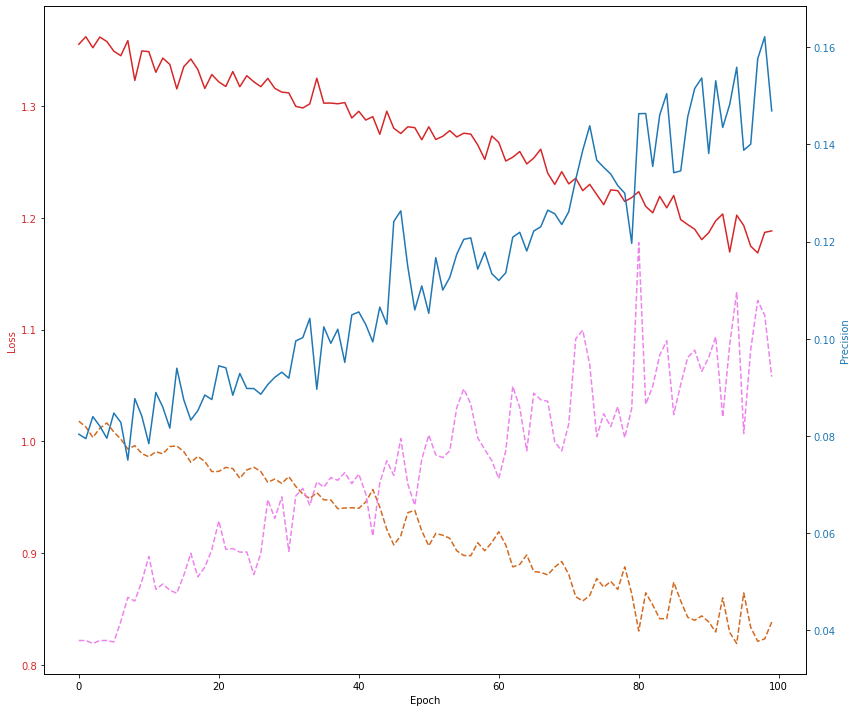

[I 2021-11-24 02:46:22,023] Trial 3 finished with value: 0.07337279989916123 and parameters: {'lr': 3.944426375130759e-06, 'weight_decay': 0.00042842849599118493, 'num_layers': 5, 'hidden_channels': 520}. Best is trial 1 with value: 0.16867568939624616.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 1.7122 | precision_score 0.0638 | matthews_corrcoef -0.0229 | accuracy 0.8090
loss 0.9162 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

Epoch 20
loss 1.2985 | precision_score 0.0993 | matthews_corrcoef 0.0745 | accuracy 0.4972
loss 0.9285 | precision_score 0.1525 | matthews_corrcoef 0.2227 | accuracy 0.8782

Epoch 40
loss 1.1628 | precision_score 0.1831 | matthews_corrcoef 0.2187 | accuracy 0.7615
loss 0.8023 | precision_score 0.1575 | matthews_corrcoef 0.2628 | accuracy 0.8598

Epoch 60
loss 1.0864 | precision_score 0.1879 | matthews_corrcoef 0.2402 | accuracy 0.7524
loss 0.7641 | precision_score 0.1402 | matthews_corrcoef 0.2409 | accuracy 0.8414

Epoch 80
loss 1.0626 | precision_score 0.2497 | matthews_corrcoef 0.3063 | accuracy 0.8227
loss 0.7707 | precision_score 0.1278 | matthews_corrcoef 0.2238 | accuracy 0.8250



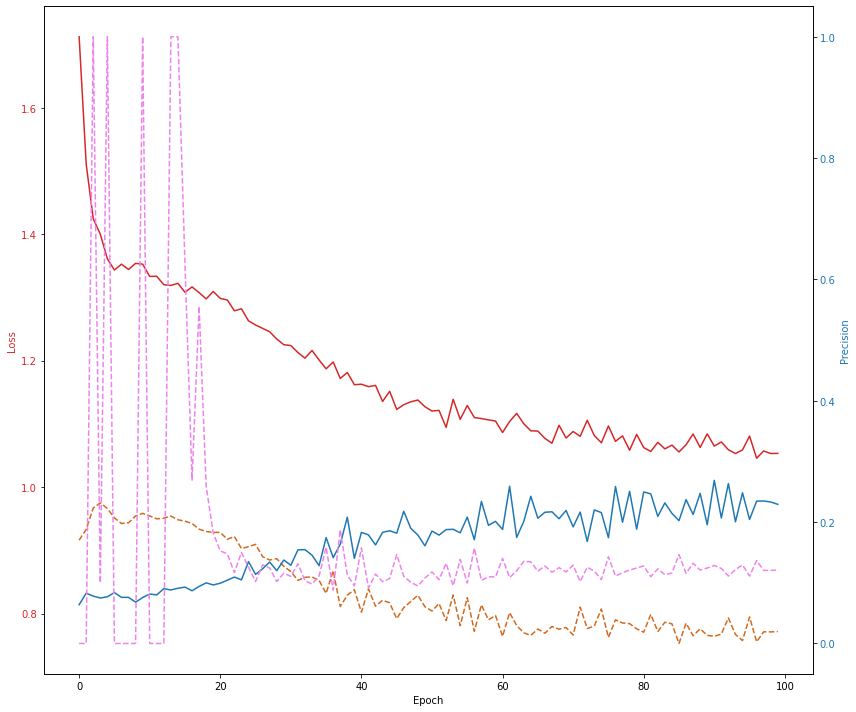

[I 2021-11-24 02:47:59,709] Trial 4 finished with value: 0.16653247708729194 and parameters: {'lr': 0.00045175907958522517, 'weight_decay': 0.0015666400960231862, 'num_layers': 3, 'hidden_channels': 20}. Best is trial 1 with value: 0.16867568939624616.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 5.4857 | precision_score 0.0893 | matthews_corrcoef 0.0367 | accuracy 0.4743
loss 1.1498 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 0.9596 | precision_score 0.2340 | matthews_corrcoef 0.3161 | accuracy 0.7935
loss 0.6069 | precision_score 0.3467 | matthews_corrcoef 0.4665 | accuracy 0.9386

Epoch 40
loss 0.8347 | precision_score 0.2900 | matthews_corrcoef 0.3896 | accuracy 0.8348
loss 0.6192 | precision_score 0.1842 | matthews_corrcoef 0.3291 | accuracy 0.8639

Epoch 60
loss 0.8319 | precision_score 0.2869 | matthews_corrcoef 0.3905 | accuracy 0.8311
loss 0.5213 | precision_score 0.3485 | matthews_corrcoef 0.4380 | accuracy 0.9417

Epoch 80
loss 0.7761 | precision_score 0.3219 | matthews_corrcoef 0.4357 | accuracy 0.8510
loss 0.6306 | precision_score 0.2301 | matthews_corrcoef 0.3642 | accuracy

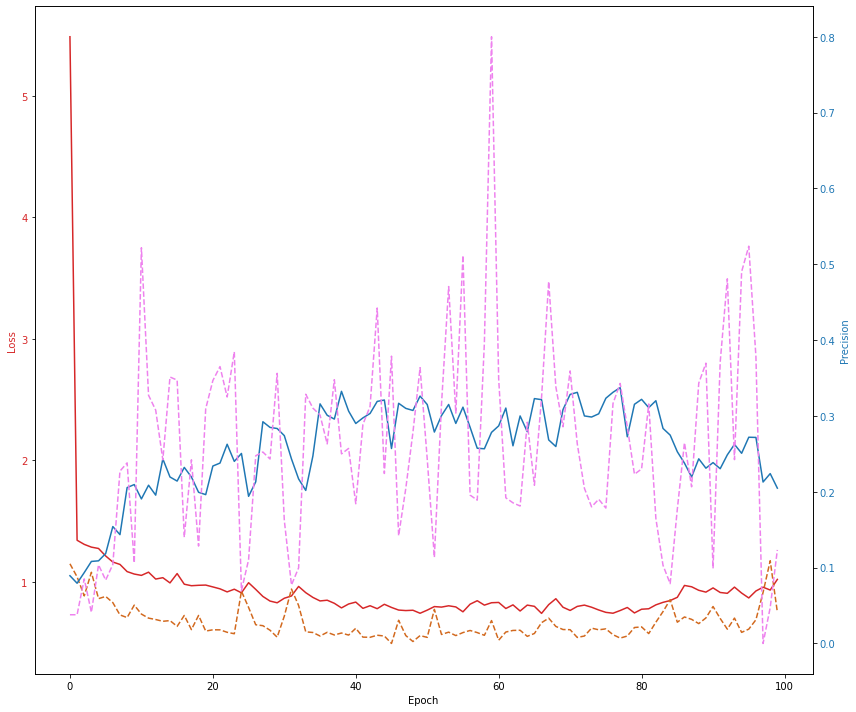

[I 2021-11-24 02:54:40,469] Trial 5 finished with value: 0.2582699813600665 and parameters: {'lr': 0.003443360276897034, 'weight_decay': 3.437657176543441e-06, 'num_layers': 4, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3564 | precision_score 0.0851 | matthews_corrcoef 0.0211 | accuracy 0.4426
loss 1.0117 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 20
loss 1.2189 | precision_score 0.1510 | matthews_corrcoef 0.1800 | accuracy 0.6949
loss 0.8996 | precision_score 0.0750 | matthews_corrcoef 0.1486 | accuracy 0.6489

Epoch 40
loss 1.1313 | precision_score 0.2057 | matthews_corrcoef 0.2421 | accuracy 0.7932
loss 0.8561 | precision_score 0.0808 | matthews_corrcoef 0.1487 | accuracy 0.7073

Epoch 60
loss 1.1149 | precision_score 0.1869 | matthews_corrcoef 0.2413 | accuracy 0.7485
loss 0.8311 | precision_score 0.0888 | matthews_corrcoef 0.1603 | accuracy 0.7441

Epoch 80
loss 1.0780 | precision_score 0.2195 | matthews_corrcoef 0.2802 | accuracy 0.7910
loss 0.8040 | precision_score 0.1031 | matthews_corrcoef 0.1860 | accuracy 0.7810



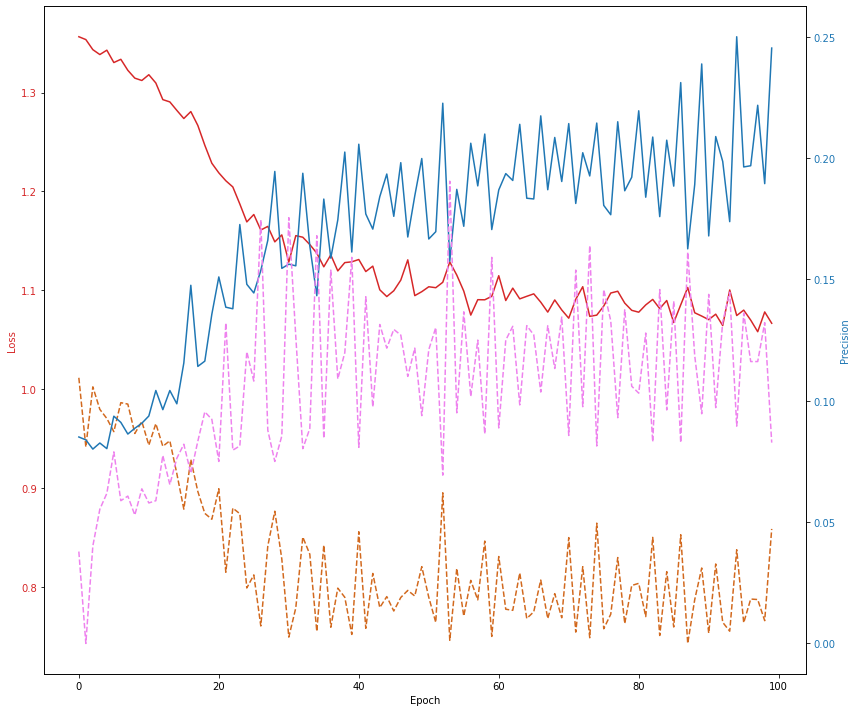

[I 2021-11-24 03:02:47,430] Trial 6 finished with value: 0.10651753016701321 and parameters: {'lr': 4.1469508685551376e-05, 'weight_decay': 0.006752815218270218, 'num_layers': 5, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 1.4419 | precision_score 0.0806 | matthews_corrcoef 0.0010 | accuracy 0.6356
loss 0.9656 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 1.3855 | precision_score 0.0823 | matthews_corrcoef 0.0080 | accuracy 0.4903
loss 1.0239 | precision_score 0.0353 | matthews_corrcoef -0.0637 | accuracy 0.0727

Epoch 40
loss 1.3554 | precision_score 0.0843 | matthews_corrcoef 0.0162 | accuracy 0.4785
loss 1.0270 | precision_score 0.0370 | matthews_corrcoef -0.0192 | accuracy 0.0901

Epoch 60
loss 1.3494 | precision_score 0.0847 | matthews_corrcoef 0.0178 | accuracy 0.4760
loss 1.0166 | precision_score 0.0401 | matthews_corrcoef 0.0270 | accuracy 0.1873

Epoch 80
loss 1.3429 | precision_score 0.0918 | matthews_corrcoef 0.0457 | accuracy 0.4871
loss 1.0072 | precision_score 0.0423 | matthews_corrcoef 0.0379 | accuracy 0.2979



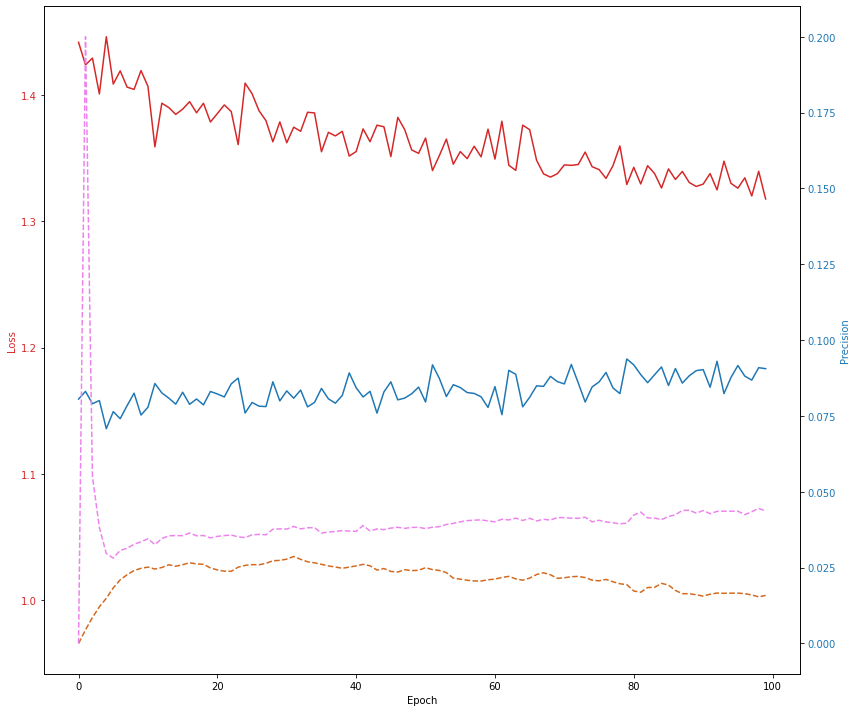

[I 2021-11-24 03:05:05,089] Trial 7 finished with value: 0.040117626734398414 and parameters: {'lr': 5.023848640222555e-06, 'weight_decay': 0.000698778113028354, 'num_layers': 4, 'hidden_channels': 120}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.4463 | precision_score 0.0813 | matthews_corrcoef 0.0044 | accuracy 0.4765
loss 0.9903 | precision_score 0.0503 | matthews_corrcoef 0.0817 | accuracy 0.4135

Epoch 20
loss 1.1895 | precision_score 0.1462 | matthews_corrcoef 0.1870 | accuracy 0.6567
loss 0.8354 | precision_score 0.0945 | matthews_corrcoef 0.1758 | accuracy 0.7513

Epoch 40
loss 1.1426 | precision_score 0.1460 | matthews_corrcoef 0.1914 | accuracy 0.6479
loss 0.8542 | precision_score 0.0755 | matthews_corrcoef 0.1412 | accuracy 0.6745

Epoch 60
loss 1.0744 | precision_score 0.1614 | matthews_corrcoef 0.2331 | accuracy 0.6639
loss 0.8120 | precision_score 0.0909 | matthews_corrcoef 0.1691 | accuracy 0.7410

Epoch 80
loss 1.0706 | precision_score 0.1857 | matthews_corrcoef 0.2460 | accuracy 0.7401
loss 0.8095 | precision_score 0.0879 | matthews_corrcoef 0.1632 | accuracy

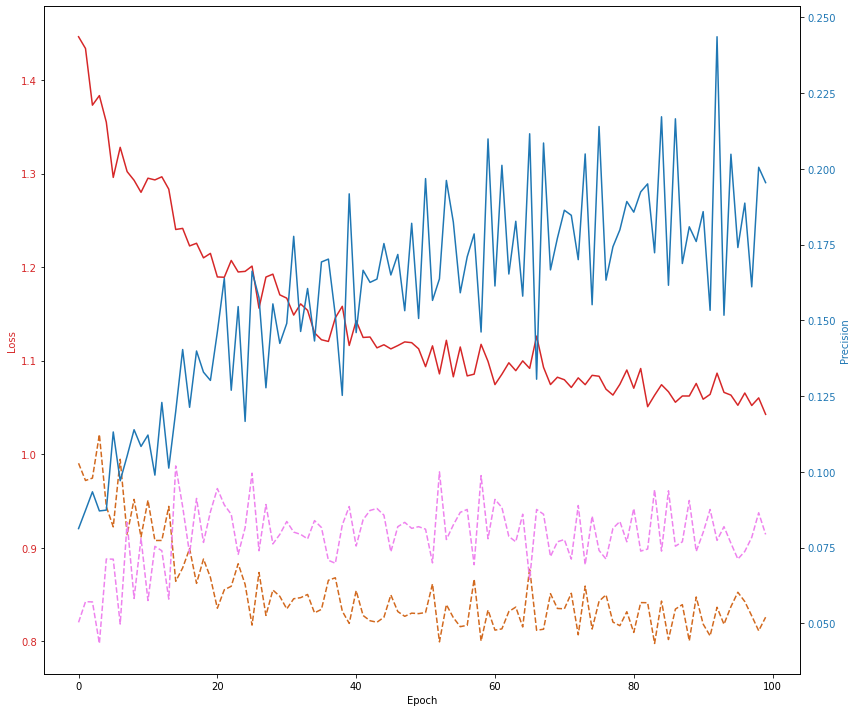

[I 2021-11-24 03:12:33,272] Trial 8 finished with value: 0.07892591675642202 and parameters: {'lr': 1.5323207709942157e-05, 'weight_decay': 4.137035397696976e-05, 'num_layers': 3, 'hidden_channels': 520}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 5.0044 | precision_score 0.0797 | matthews_corrcoef -0.0015 | accuracy 0.5232
loss 0.9176 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 1.0069 | precision_score 0.2005 | matthews_corrcoef 0.2837 | accuracy 0.7458
loss 0.7075 | precision_score 0.1290 | matthews_corrcoef 0.2316 | accuracy 0.8209

Epoch 40
loss 0.7437 | precision_score 0.3270 | matthews_corrcoef 0.4471 | accuracy 0.8525
loss 0.5985 | precision_score 0.1531 | matthews_corrcoef 0.3023 | accuracy 0.8229

Epoch 60
loss 0.6170 | precision_score 0.3762 | matthews_corrcoef 0.5103 | accuracy 0.8753
loss 0.4455 | precision_score 0.2541 | matthews_corrcoef 0.4279 | accuracy 0.9007

Epoch 80
loss 0.4372 | precision_score 0.4799 | matthews_corrcoef 0.6249 | accuracy 0.9137
loss 0.4062 | precision_score 0.3107 | matthews_corrcoef 0.4906 | accuracy 0.9222



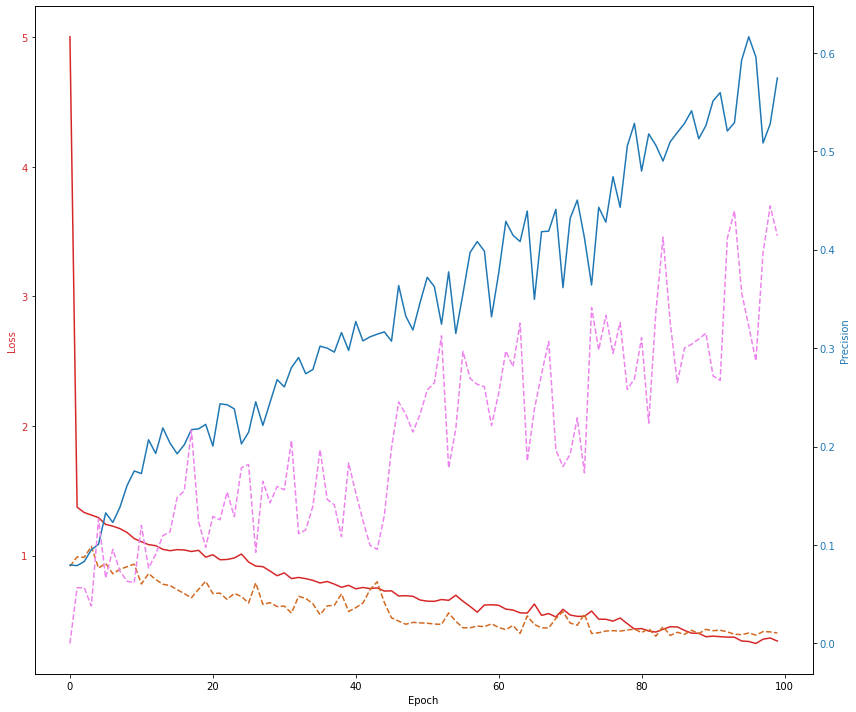

[I 2021-11-24 03:16:48,112] Trial 9 finished with value: 0.21089850679388622 and parameters: {'lr': 0.0015294022249668856, 'weight_decay': 6.502161136338155e-05, 'num_layers': 2, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 8.5886 | precision_score 0.0775 | matthews_corrcoef -0.0098 | accuracy 0.4937
loss 0.9878 | precision_score 0.0470 | matthews_corrcoef 0.0569 | accuracy 0.4289

Epoch 20
loss 1.0314 | precision_score 0.1870 | matthews_corrcoef 0.2518 | accuracy 0.7379
loss 0.9138 | precision_score 0.0671 | matthews_corrcoef 0.1407 | accuracy 0.5660

Epoch 40
loss 1.0197 | precision_score 0.1994 | matthews_corrcoef 0.2638 | accuracy 0.7605
loss 0.7118 | precision_score 0.1337 | matthews_corrcoef 0.2562 | accuracy 0.8106

Epoch 60
loss 0.9406 | precision_score 0.2211 | matthews_corrcoef 0.3105 | accuracy 0.7728
loss 0.6193 | precision_score 0.2222 | matthews_corrcoef 0.3405 | accuracy 0.9007

Epoch 80
loss 1.1210 | precision_score 0.1598 | matthews_corrcoef 0.2040 | accuracy 0.6978
loss 0.7492 | precision_score 0.1852 | matthews_corrcoef 0.2721 | accurac

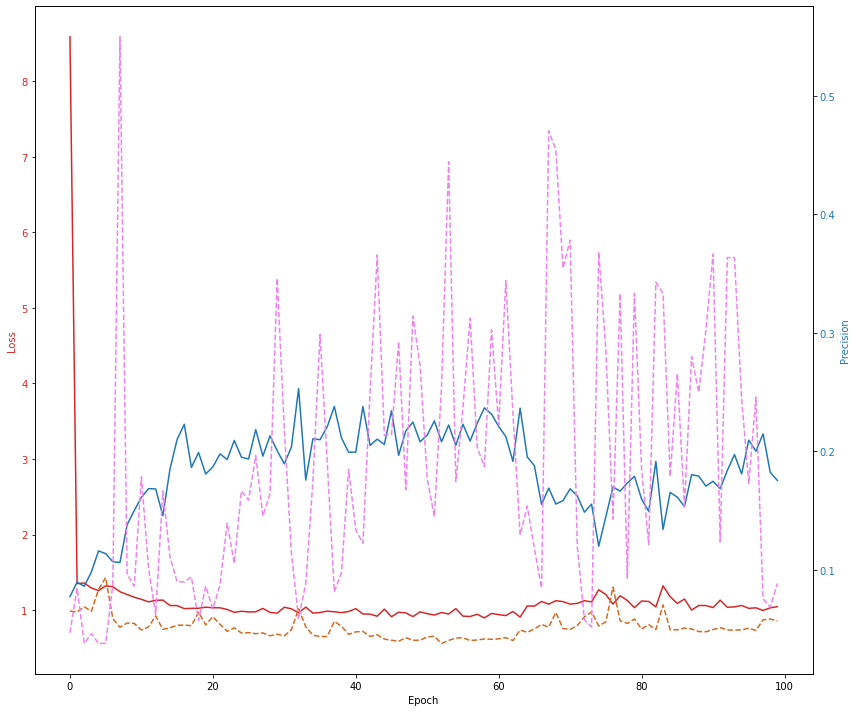

[I 2021-11-24 03:19:51,412] Trial 10 finished with value: 0.19279376788328026 and parameters: {'lr': 0.009019532552299203, 'weight_decay': 1.7518611326056967e-06, 'num_layers': 2, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 11.4287 | precision_score 0.0774 | matthews_corrcoef -0.0102 | accuracy 0.4905
loss 0.9760 | precision_score 0.0405 | matthews_corrcoef 0.0096 | accuracy 0.6602

Epoch 20
loss 1.0872 | precision_score 0.1579 | matthews_corrcoef 0.2176 | accuracy 0.6695
loss 0.7235 | precision_score 0.2400 | matthews_corrcoef 0.3053 | accuracy 0.9222

Epoch 40
loss 1.0430 | precision_score 0.1931 | matthews_corrcoef 0.2660 | accuracy 0.7416
loss 0.6869 | precision_score 0.2174 | matthews_corrcoef 0.3032 | accuracy 0.9089

Epoch 60
loss 1.0281 | precision_score 0.1741 | matthews_corrcoef 0.2369 | accuracy 0.7118
loss 0.7007 | precision_score 0.1979 | matthews_corrcoef 0.2768 | accuracy 0.9028

Epoch 80
loss 0.9713 | precision_score 0.2256 | matthews_corrcoef 0.3072 | accuracy 0.7841
loss 0.7688 | precision_score 0.1086 | matthews_corrcoef 0.2273 | accura

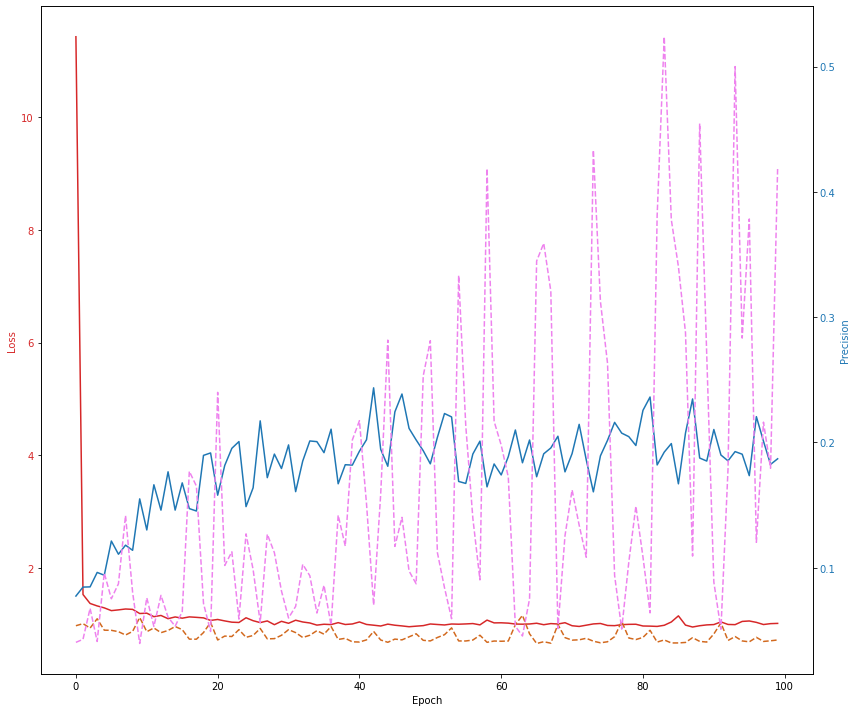

[I 2021-11-24 03:24:04,175] Trial 11 finished with value: 0.1608229595608687 and parameters: {'lr': 0.008659187844254696, 'weight_decay': 1.5728222253155644e-05, 'num_layers': 2, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.6156 | precision_score 0.0764 | matthews_corrcoef -0.0165 | accuracy 0.4209
loss 0.9082 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9387 | precision_score 0.2489 | matthews_corrcoef 0.3370 | accuracy 0.8058
loss 0.7713 | precision_score 0.1085 | matthews_corrcoef 0.2217 | accuracy 0.7554

Epoch 40
loss 0.7225 | precision_score 0.3761 | matthews_corrcoef 0.4875 | accuracy 0.8785
loss 0.6092 | precision_score 0.1475 | matthews_corrcoef 0.3068 | accuracy 0.8055

Epoch 60
loss 0.5724 | precision_score 0.4367 | matthews_corrcoef 0.5632 | accuracy 0.9002
loss 0.4291 | precision_score 0.2743 | matthews_corrcoef 0.4480 | accuracy 0.9099

Epoch 80
loss 0.4305 | precision_score 0.4771 | matthews_corrcoef 0.6276 | accuracy 0.9127
loss 0.4031 | precision_score 0.3506 | matthews_corrcoef 0.4793 | accuracy 0.9386



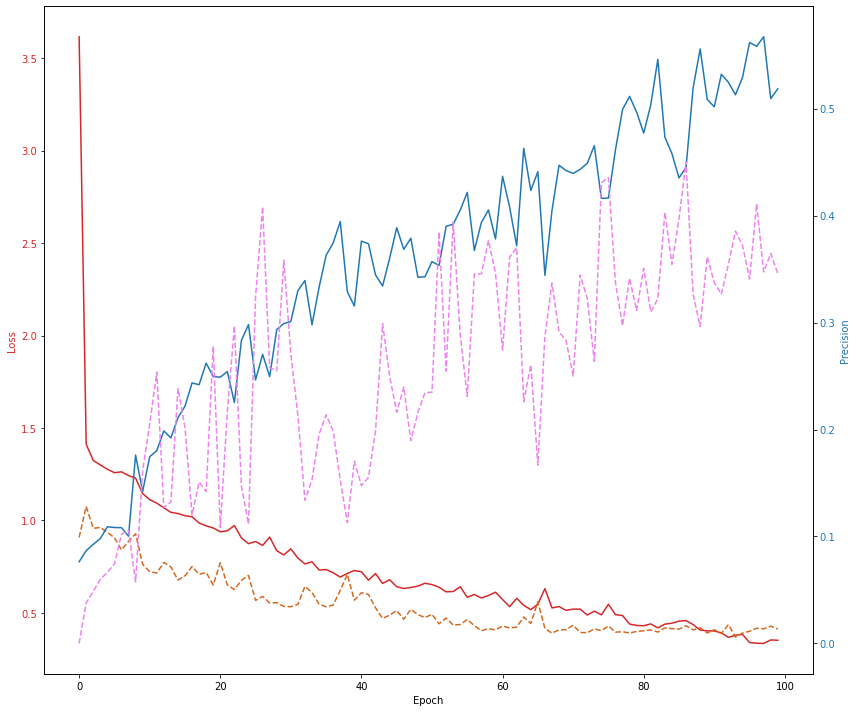

[I 2021-11-24 03:27:08,580] Trial 12 finished with value: 0.2555535528023482 and parameters: {'lr': 0.001164884005365969, 'weight_decay': 3.7540522058417304e-06, 'num_layers': 2, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 3.2784 | precision_score 0.0841 | matthews_corrcoef 0.0138 | accuracy 0.5208
loss 1.0615 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.0081 | precision_score 0.2535 | matthews_corrcoef 0.3141 | accuracy 0.8237
loss 0.6774 | precision_score 0.2593 | matthews_corrcoef 0.3487 | accuracy 0.9222

Epoch 40
loss 0.7751 | precision_score 0.3356 | matthews_corrcoef 0.4400 | accuracy 0.8608
loss 0.7949 | precision_score 0.0920 | matthews_corrcoef 0.2057 | accuracy 0.6807

Epoch 60
loss 0.6597 | precision_score 0.3739 | matthews_corrcoef 0.4959 | accuracy 0.8761
loss 0.5073 | precision_score 0.2500 | matthews_corrcoef 0.4079 | accuracy 0.9028

Epoch 80
loss 0.6686 | precision_score 0.3424 | matthews_corrcoef 0.4812 | accuracy 0.8571
loss 0.4356 | precision_score 0.3111 | matthews_corrcoef 0.4560 | accuracy

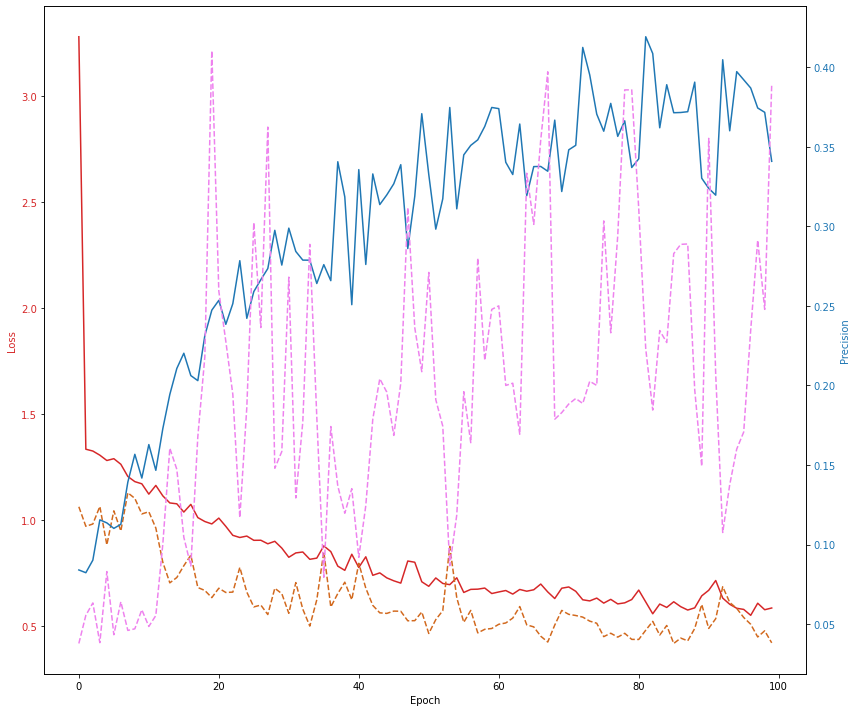

[I 2021-11-24 03:31:46,435] Trial 13 finished with value: 0.19614748548860353 and parameters: {'lr': 0.002938611287145778, 'weight_decay': 1.366538292947111e-06, 'num_layers': 4, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.4573 | precision_score 0.0884 | matthews_corrcoef 0.0354 | accuracy 0.4485
loss 0.9571 | precision_score 0.0529 | matthews_corrcoef 0.0409 | accuracy 0.7718

Epoch 20
loss 1.0697 | precision_score 0.1914 | matthews_corrcoef 0.2523 | accuracy 0.7502
loss 0.7706 | precision_score 0.1070 | matthews_corrcoef 0.1923 | accuracy 0.7892

Epoch 40
loss 0.9145 | precision_score 0.2322 | matthews_corrcoef 0.3287 | accuracy 0.7826
loss 0.9385 | precision_score 0.0651 | matthews_corrcoef 0.1481 | accuracy 0.5107

Epoch 60
loss 0.8114 | precision_score 0.2845 | matthews_corrcoef 0.4051 | accuracy 0.8230
loss 0.5991 | precision_score 0.1637 | matthews_corrcoef 0.3037 | accuracy 0.8444

Epoch 80
loss 0.7409 | precision_score 0.3342 | matthews_corrcoef 0.4507 | accuracy 0.8574
loss 0.5560 | precision_score 0.1703 | matthews_corrcoef 0.3320 | accuracy

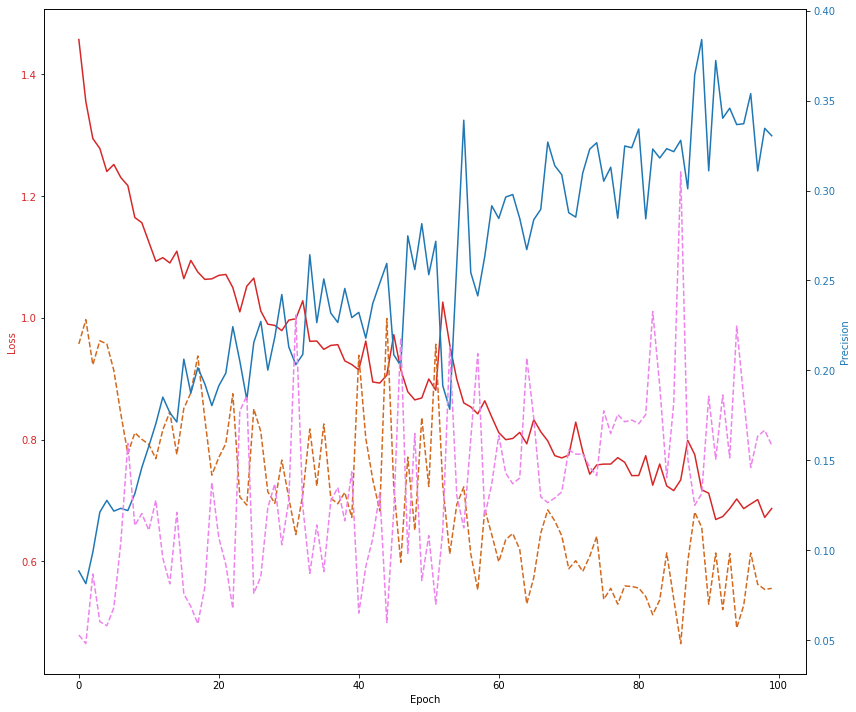

[I 2021-11-24 03:35:39,924] Trial 14 finished with value: 0.1341448470939642 and parameters: {'lr': 0.0002064622156829893, 'weight_decay': 7.580279465543369e-06, 'num_layers': 3, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3660 | precision_score 0.0788 | matthews_corrcoef -0.0064 | accuracy 0.3993
loss 1.0068 | precision_score 0.0393 | matthews_corrcoef 0.0290 | accuracy 0.0983

Epoch 20
loss 1.1019 | precision_score 0.2069 | matthews_corrcoef 0.2649 | accuracy 0.7770
loss 0.8415 | precision_score 0.0875 | matthews_corrcoef 0.1576 | accuracy 0.7400

Epoch 40
loss 1.0461 | precision_score 0.2048 | matthews_corrcoef 0.2759 | accuracy 0.7632
loss 0.7469 | precision_score 0.1469 | matthews_corrcoef 0.2364 | accuracy 0.8588

Epoch 60
loss 0.9781 | precision_score 0.2416 | matthews_corrcoef 0.3212 | accuracy 0.8030
loss 0.6854 | precision_score 0.2233 | matthews_corrcoef 0.3335 | accuracy 0.9038

Epoch 80
loss 0.9301 | precision_score 0.2769 | matthews_corrcoef 0.3530 | accuracy 0.8343
loss 0.6533 | precision_score 0.1852 | matthews_corrcoef 0.3090 | accurac

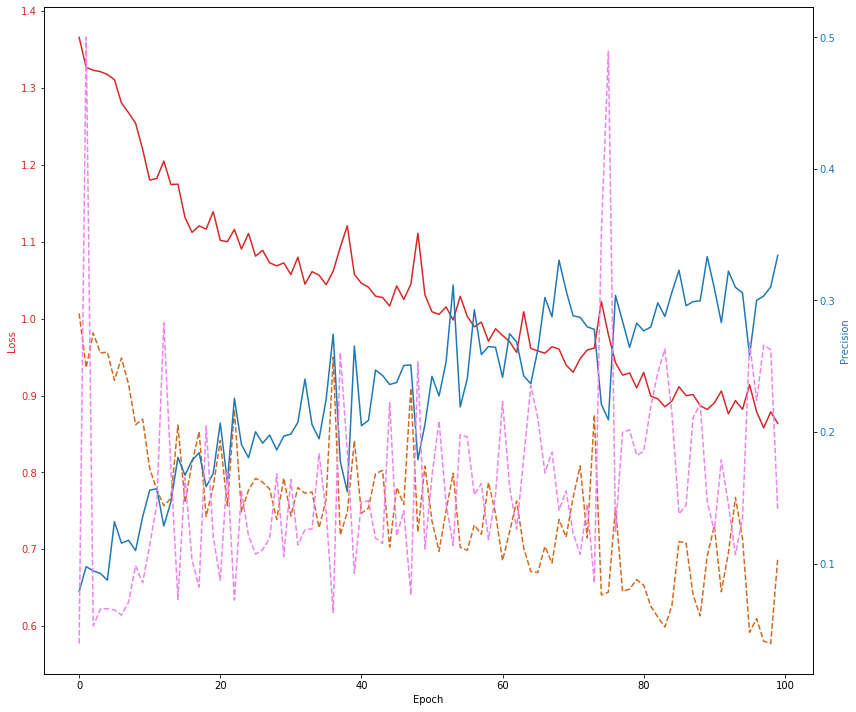

[I 2021-11-24 03:39:39,419] Trial 15 finished with value: 0.15937317604032988 and parameters: {'lr': 0.0001367543538115252, 'weight_decay': 6.634249942772138e-06, 'num_layers': 5, 'hidden_channels': 220}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 10.6322 | precision_score 0.0733 | matthews_corrcoef -0.0237 | accuracy 0.5218
loss 1.1359 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.0427 | precision_score 0.2017 | matthews_corrcoef 0.2820 | accuracy 0.7504
loss 0.6495 | precision_score 0.2923 | matthews_corrcoef 0.3559 | accuracy 0.9345

Epoch 40
loss 0.9256 | precision_score 0.2147 | matthews_corrcoef 0.3076 | accuracy 0.7610
loss 0.5647 | precision_score 0.3333 | matthews_corrcoef 0.4463 | accuracy 0.9365

Epoch 60
loss 0.8680 | precision_score 0.2574 | matthews_corrcoef 0.3608 | accuracy 0.8062
loss 0.7716 | precision_score 0.1038 | matthews_corrcoef 0.2398 | accuracy 0.7042

Epoch 80
loss 0.7802 | precision_score 0.2807 | matthews_corrcoef 0.3831 | accuracy 0.8269
loss 0.4878 | precision_score 0.3034 | matthews_corrcoef 0.4403 | accura

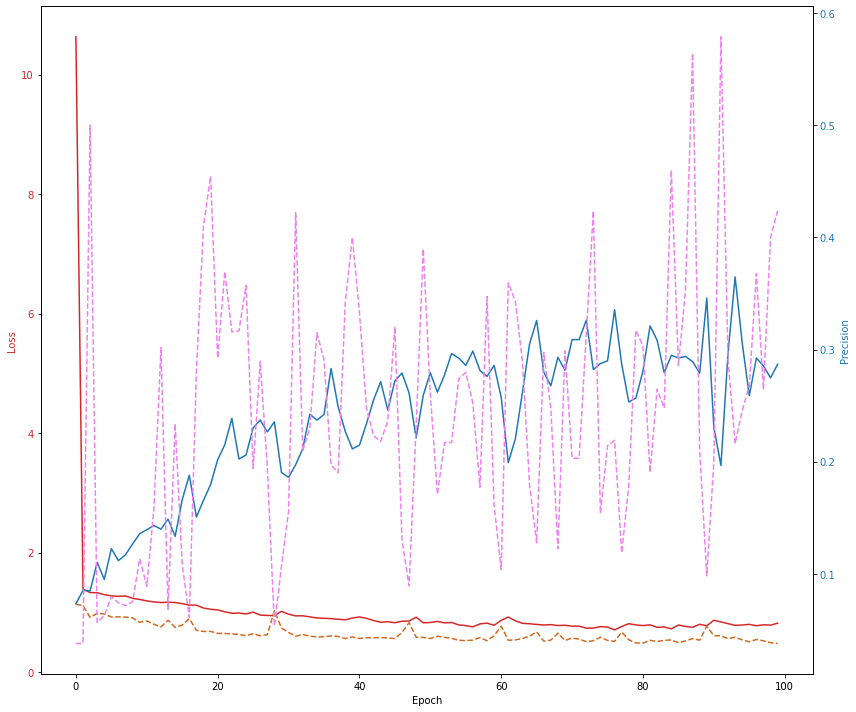

[I 2021-11-24 03:45:15,669] Trial 16 finished with value: 0.24240943334545212 and parameters: {'lr': 0.0028151840375554185, 'weight_decay': 3.2540157935713793e-06, 'num_layers': 2, 'hidden_channels': 520}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.4521 | precision_score 0.0854 | matthews_corrcoef 0.0201 | accuracy 0.4927
loss 1.0448 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.0218 | precision_score 0.2482 | matthews_corrcoef 0.3172 | accuracy 0.8151
loss 0.7961 | precision_score 0.1096 | matthews_corrcoef 0.2020 | accuracy 0.7871

Epoch 40
loss 0.8733 | precision_score 0.2873 | matthews_corrcoef 0.3767 | accuracy 0.8365
loss 0.6585 | precision_score 0.1753 | matthews_corrcoef 0.3115 | accuracy 0.8598

Epoch 60
loss 0.7625 | precision_score 0.2963 | matthews_corrcoef 0.4103 | accuracy 0.8343
loss 0.5974 | precision_score 0.1542 | matthews_corrcoef 0.3102 | accuracy 0.8199

Epoch 80
loss 0.6374 | precision_score 0.3701 | matthews_corrcoef 0.5049 | accuracy 0.8724
loss 0.5146 | precision_score 0.1958 | matthews_corrcoef 0.3426 | accuracy

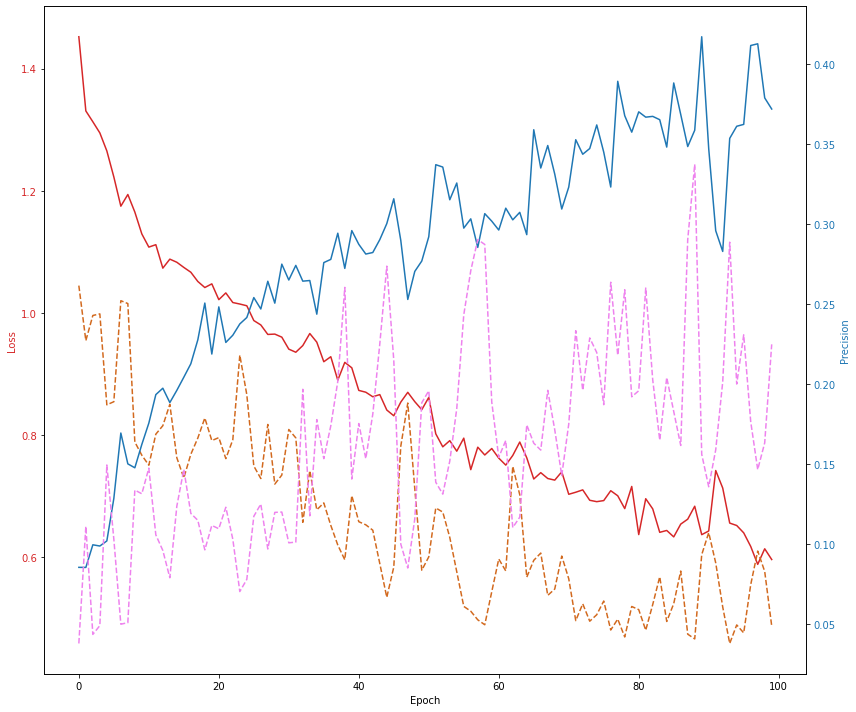

[I 2021-11-24 03:47:17,054] Trial 17 finished with value: 0.16290036723905055 and parameters: {'lr': 0.0007270885889303905, 'weight_decay': 2.3094305137797604e-05, 'num_layers': 3, 'hidden_channels': 120}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 3.5920 | precision_score 0.0826 | matthews_corrcoef 0.0087 | accuracy 0.5225
loss 1.0533 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 0.9988 | precision_score 0.2534 | matthews_corrcoef 0.3160 | accuracy 0.8227
loss 0.6002 | precision_score 0.2759 | matthews_corrcoef 0.3898 | accuracy 0.9222

Epoch 40
loss 0.7669 | precision_score 0.3421 | matthews_corrcoef 0.4482 | accuracy 0.8638
loss 0.7696 | precision_score 0.1041 | matthews_corrcoef 0.2405 | accuracy 0.7052

Epoch 60
loss 0.6991 | precision_score 0.3736 | matthews_corrcoef 0.4944 | accuracy 0.8761
loss 0.4470 | precision_score 0.3086 | matthews_corrcoef 0.4265 | accuracy 0.9304

Epoch 80
loss 0.6061 | precision_score 0.3815 | matthews_corrcoef 0.5174 | accuracy 0.8776
loss 0.4363 | precision_score 0.2520 | matthews_corrcoef 0.4335 | accuracy

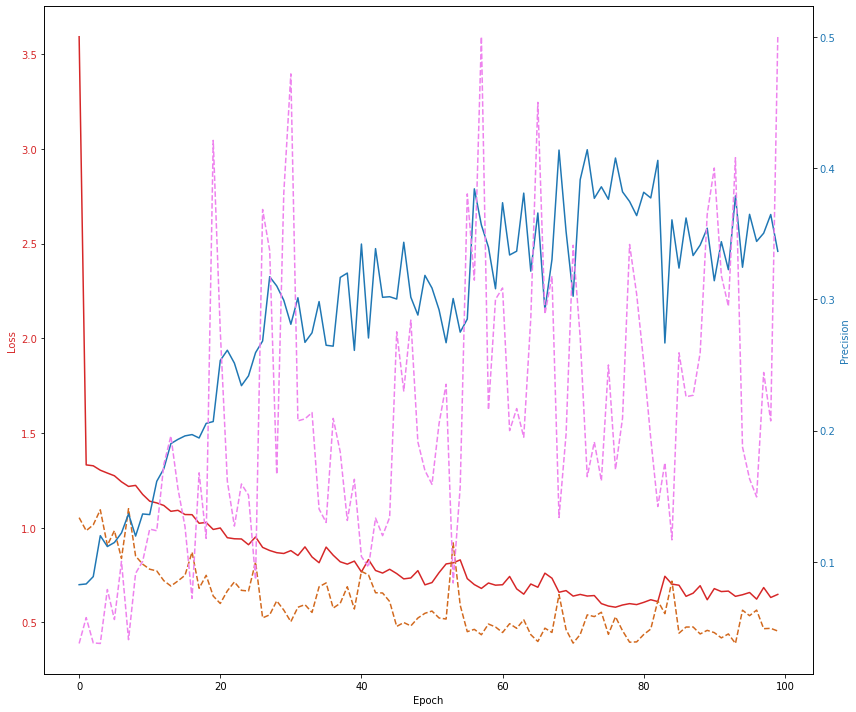

[I 2021-11-24 03:51:53,792] Trial 18 finished with value: 0.20972499433775585 and parameters: {'lr': 0.003249556735446683, 'weight_decay': 5.09072226421262e-06, 'num_layers': 4, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3469 | precision_score 0.0824 | matthews_corrcoef 0.0106 | accuracy 0.3964
loss 0.9396 | precision_score 0.0000 | matthews_corrcoef -0.0064 | accuracy 0.9611

Epoch 20
loss 1.0986 | precision_score 0.1895 | matthews_corrcoef 0.2521 | accuracy 0.7450
loss 0.7930 | precision_score 0.1144 | matthews_corrcoef 0.2041 | accuracy 0.8035

Epoch 40
loss 1.0394 | precision_score 0.2327 | matthews_corrcoef 0.3018 | accuracy 0.8001
loss 0.8144 | precision_score 0.1034 | matthews_corrcoef 0.1917 | accuracy 0.7738

Epoch 60
loss 0.9735 | precision_score 0.2533 | matthews_corrcoef 0.3236 | accuracy 0.8188
loss 0.7607 | precision_score 0.1194 | matthews_corrcoef 0.2174 | accuracy 0.8055

Epoch 80
loss 0.9243 | precision_score 0.2862 | matthews_corrcoef 0.3776 | accuracy 0.8350
loss 0.7506 | precision_score 0.1167 | matthews_corrcoef 0.2356 | accurac

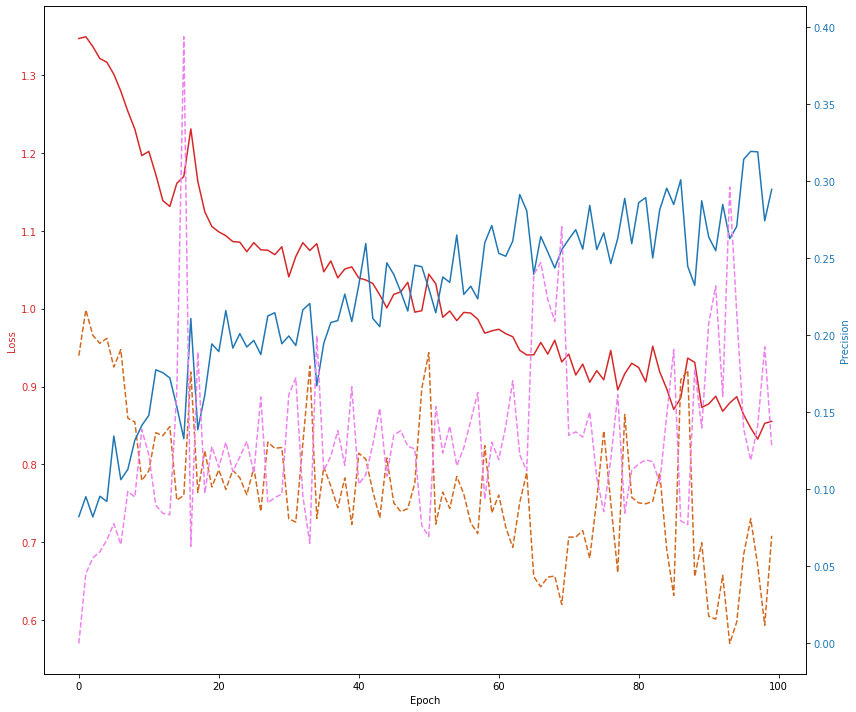

[I 2021-11-24 03:59:58,557] Trial 19 finished with value: 0.1328728983149037 and parameters: {'lr': 7.431037664728423e-05, 'weight_decay': 1.215243090073585e-06, 'num_layers': 5, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  0.2582699813600665
  Params: 
    lr: 0.003443360276897034
    weight_decay: 3.437657176543441e-06
    num_layers: 4
    hidden_channels: 420


In [8]:
def objective_fp(trial):
    batch_size_test = 40
    root = '/content/drive/MyDrive/GNN/testing'
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_ampc.csv' 
    test_dataloader, _ = get_dataset_and_weight(
        root, test_file_name, batch_size_test, shuffle=False)

    # OPTUNA
    batch_size_train = 500 #trial.suggest_int('batch_size', 411, 511, step=100)
    root = '/content/drive/MyDrive/GNN/training'
    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_ampc.csv' 
    model, criterion, optimizer, train_dataloader = get_all_optuna(trial, root, train_file_name, batch_size_train, shuffle=True)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 100
    test_precision_score_mean, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)

    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    #AX1
    fig, ax1 = plt.subplots(figsize=(12,10))
    #figure(figsize=(18, 16), dpi=300)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Loss
    t = range(EPOCHS)
    ax1.plot(t, train_total_loss, color='tab:red')
    ax1.plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # AX2
    # Presicion
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Precision', color='tab:blue')  
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax2.plot(t, train_precision_score, color='tab:blue')
    ax2.plot(t, test_precision_score, color='violet', linestyle='dashed')

    fig.tight_layout() 
    plt.show()

    # Training of the model.
    return test_precision_score_mean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
study.best_trials

[FrozenTrial(number=10, values=[1.0], datetime_start=datetime.datetime(2021, 11, 23, 17, 20, 8, 542162), datetime_complete=datetime.datetime(2021, 11, 23, 17, 36, 14, 801236), params={'batch_size': 511, 'lr': 0.0072660536360049715, 'weight_decay': 1.3232358675656123e-05, 'num_layers': 3, 'hidden_channels': 300, 'dropout': 0.7}, distributions={'batch_size': IntUniformDistribution(high=511, low=411, step=100), 'lr': LogUniformDistribution(high=0.01, low=1e-08), 'weight_decay': LogUniformDistribution(high=0.01, low=1e-08), 'num_layers': IntUniformDistribution(high=3, low=1, step=1), 'hidden_channels': IntUniformDistribution(high=400, low=100, step=100), 'dropout': DiscreteUniformDistribution(high=0.7, low=0.4, q=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=10, state=TrialState.COMPLETE, value=None)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



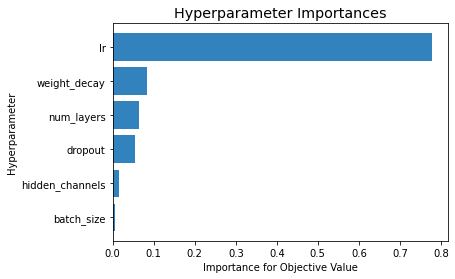

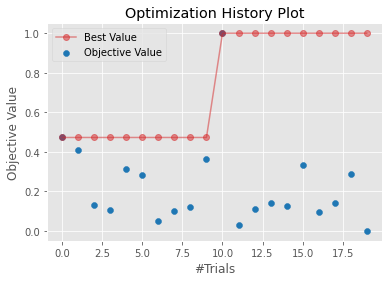

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);
plot_optimization_history(study);

---